In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from dataloader import *

In [3]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [4]:
ANNOT_PATH = "new_data/full_facescrub_with_ids.txt"
DATA_PATH = "new_data/"

In [5]:
df = pd.read_csv(ANNOT_PATH, delimiter='\t')

In [6]:
265*0.2

53.0

In [19]:
random_state = np.random.RandomState(1791387)
holdout_male_pids = random_state.randint(1, 266, size=int(265*0.2))
# holdout_female_pids = random_state.randint(1, 266, size=int(265*0.2))

val_male_pids = random_state.choice(holdout_male_pids, size=int(265*0.1), replace=False)
# test_male_pids = list(set(holdout_male_pids) - set(val_male_pids))
test_male_pids = np.setdiff1d(holdout_male_pids, val_male_pids)
print(holdout_male_pids)
print(val_male_pids)
print(test_male_pids)

[ 56  97 152 249   4 203   1 152 101 171  31 135 169  85 143 210 110 193
 127 158 164 160 123  52  76 203 113  90  30  81  17 170  24 105 235 183
 115 197  84 187  31  99 204  84  71 222  45  92 164 107 128 205 203]
[123 204  45 183 170 169  90 171 110 160 164 152  52 187  84  92  76  85
 210  24  97  84 164 203 152 143]
[  1   4  17  30  31  56  71  81  99 101 105 107 113 115 127 128 135 158
 193 197 205 222 235 249]


In [47]:
def data_split(low=1, class_size=265, holdout_frac=0.2, val_test_split=0.5, seed=1791387):
    random_state = np.random.RandomState(seed)
    all_pids = np.arange(low, low+class_size+1)
    holdout_pids = random_state.randint(low, low+class_size+1, size=int(class_size*holdout_frac))
    val_pids = random_state.choice(holdout_pids, size=int(class_size*holdout_frac*val_test_split), replace=False)
    test_pids = np.setdiff1d(holdout_pids, val_pids)
    train_pids = np.setdiff1d(all_pids, holdout_pids)
    return train_pids, val_pids, test_pids

In [48]:
male_train, male_val, male_test = data_split()
female_train, female_val, female_test = data_split(low=265)

In [61]:
np.concatenate((male_train, female_train))

array([  2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  18,  19,  20,  21,  22,  23,  25,  26,  27,  28,  29,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  46,
        47,  48,  49,  50,  51,  53,  54,  55,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  72,  73,  74,  75,
        77,  78,  79,  80,  82,  83,  86,  87,  88,  89,  91,  93,  94,
        95,  96,  98, 100, 102, 103, 104, 106, 108, 109, 111, 112, 114,
       116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 129, 130, 131,
       132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146,
       147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 161, 162,
       163, 165, 166, 167, 168, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 184, 185, 186, 188, 189, 190, 191, 192, 194, 195,
       196, 198, 199, 200, 201, 202, 206, 207, 208, 209, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 22

In [64]:
train_df = df[df.person_id.isin(np.concatenate((male_train, female_train)))]
len(train_df.person_id.unique())

437

In [33]:
pids = df.person_id.unique()
pids_to_indices = {ids: np.where(df.person_id == ids)[0] for ids in pids}
pids_to_indices[530]
pids[2]

3

In [76]:
random_state = np.random.RandomState(1791387)
positive_pairs = [[i, random_state.choice(pids_to_indices[df.person_id[i].item()]),1] for i in range(0, len(df), 2)]
negative_pairs = [[i, random_state.choice(pids_to_indices[np.random.choice(list(set(pids) - set([df.person_id[i].item()])))]), 0] for i in range(0, len(df), 2)]
test_pairs = positive_pairs + negative_pairs

In [81]:
triplets = [[i, 
                   random_state.choice(pids_to_indices[df.person_id[i].item()]),
                   random_state.choice(pids_to_indices[np.random.choice(list(set(pids) - set([df.person_id[i].item()])))])
                  ] for i in range(0, len(df))]

In [82]:
triplets[-5:]

[[37910, 37900, 2190],
 [37911, 37878, 18644],
 [37912, 37886, 36323],
 [37913, 37892, 29881],
 [37914, 37886, 14835]]

In [85]:
print(df.iloc[triplets[200][0]])
print(df.iloc[triplets[200][1]])
print(df.iloc[triplets[200][2]])


name                                                Adam McKay
image_id                                                   979
face_id                                                    533
url          http://www.localbozo.com/wp-content/uploads/20...
bbox                                           550,148,671,269
sha256       c53dd91b7a5a6460475714aac0338d188dbf7fb4aaeff6...
gender                                                    male
person_id                                                    3
Name: 200, dtype: object
name                                                Adam McKay
image_id                                                   906
face_id                                                    514
url          http://www4.pictures.zimbio.com/gi/Adam%252BMc...
bbox                                            216,64,414,262
sha256       0f9f3ae182a8146dc90478f677783158cedbf4ed35952e...
gender                                                    male
person_id                     

In [77]:
test_pairs[-5:]

[[37906, 35182, 0],
 [37908, 8050, 0],
 [37910, 27304, 0],
 [37912, 25201, 0],
 [37914, 13226, 0]]

In [57]:
print(df.person_id[positive_pairs[2000][0]])
print(df.person_id[positive_pairs[2000][1]])

Chris Kattan
Chris Kattan


In [73]:
df.columns

Index(['name', 'image_id', 'face_id', 'url', 'bbox', 'sha256', 'gender',
       'person_id'],
      dtype='object')

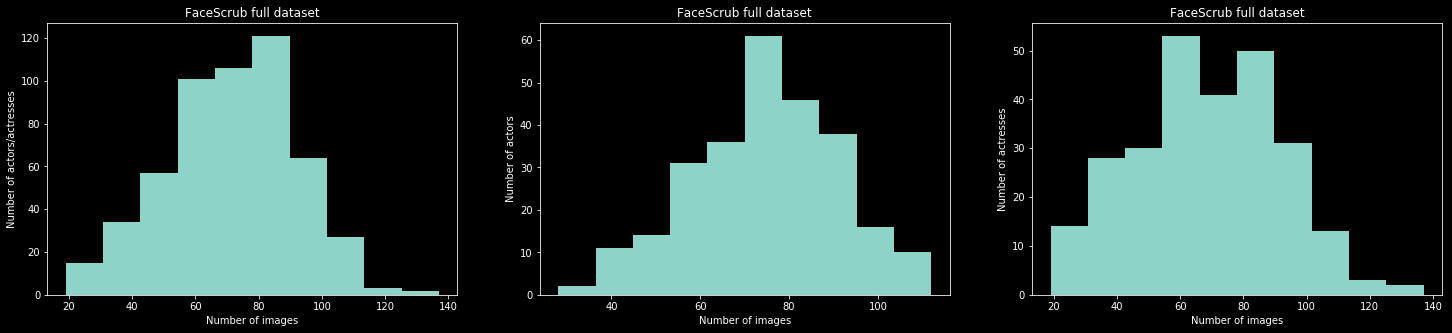

(array([ 15.,  34.,  57., 101., 106., 121.,  64.,  27.,   3.,   2.]), array([ 19. ,  30.8,  42.6,  54.4,  66.2,  78. ,  89.8, 101.6, 113.4,
       125.2, 137. ]), <a list of 10 Patch objects>)


In [74]:
plt.figure(figsize=(25, 5))
plt.subplot(131)
arr = plt.hist(df.name.value_counts())
plt.xlabel('Number of images')
plt.ylabel('Number of actors/actresses')
plt.title('FaceScrub full dataset')

plt.subplot(132)
plt.hist(df[df['gender'] == 'male'].name.value_counts())
plt.xlabel('Number of images')
plt.ylabel('Number of actors')
plt.title('FaceScrub full dataset')

plt.subplot(133)
plt.hist(df[df['gender'] == 'female'].name.value_counts())
plt.xlabel('Number of images')
plt.ylabel('Number of actresses')
plt.title('FaceScrub full dataset')


plt.show()

print(arr)

In [75]:
gender_counts = df.gender.value_counts()
gender_counts

male      19741
female    18174
Name: gender, dtype: int64

In [76]:
males_to_drop = gender_counts['male'] - gender_counts['female']
print(males_to_drop)

1567


In [77]:
eq_df = df.copy()
eq_df[df['gender'] == 'male'] = df[df['gender']=='male'].sample(n=gender_counts['female'])
eq_df.gender.value_counts()

female    18174
male      18174
Name: gender, dtype: int64

In [89]:
eq_df = eq_df.dropna()

In [90]:
sum(eq_df.person_id.isna())

0

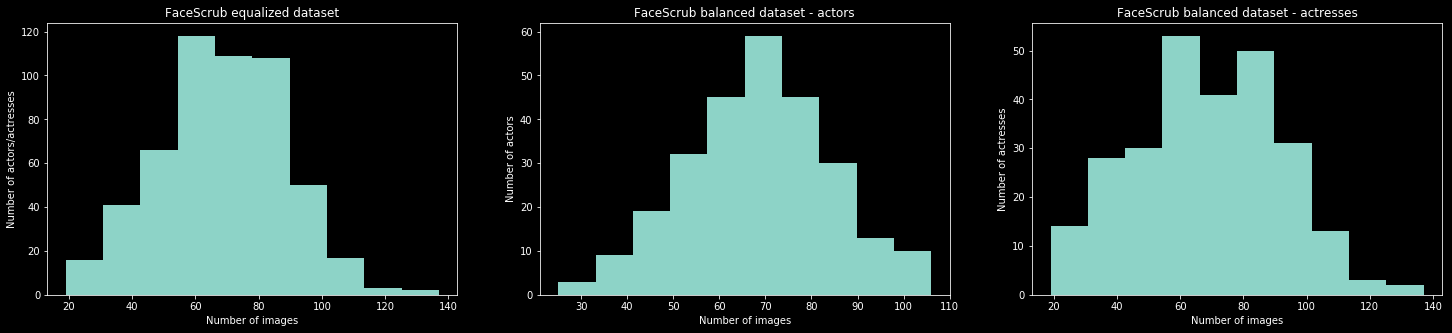

In [91]:
plt.figure(figsize=(25, 5))
plt.subplot(131)
arr = plt.hist(eq_df.name.value_counts())
plt.xlabel('Number of images')
plt.ylabel('Number of actors/actresses')
plt.title('FaceScrub equalized dataset')

plt.subplot(132)
plt.hist(eq_df[eq_df['gender'] == 'male'].name.value_counts())
plt.xlabel('Number of images')
plt.ylabel('Number of actors')
plt.title('FaceScrub balanced dataset - actors')

plt.subplot(133)
plt.hist(eq_df[eq_df['gender'] == 'female'].name.value_counts())
plt.xlabel('Number of images')
plt.ylabel('Number of actresses')
plt.title('FaceScrub balanced dataset - actresses')


plt.show()

In [92]:
sum(eq_df.person_id.isna())

0

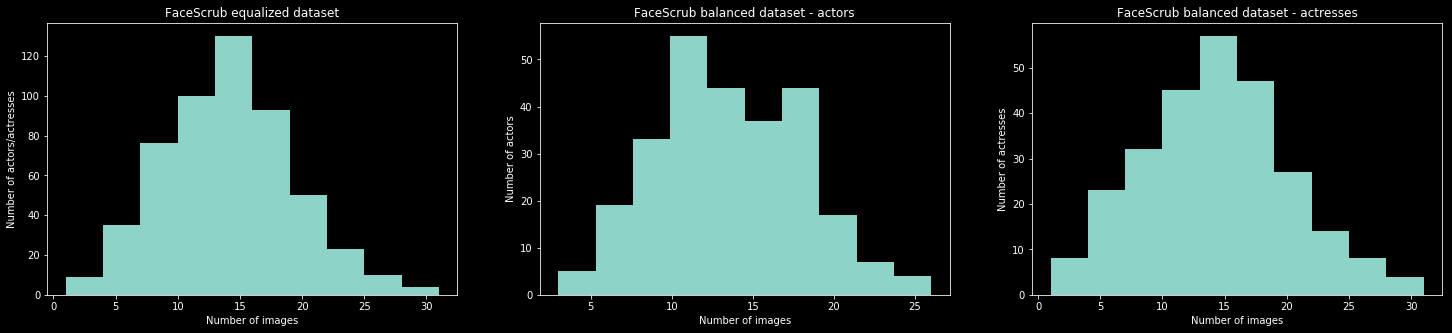

In [93]:
plt.figure(figsize=(25, 5))
plt.subplot(131)
arr = plt.hist(val_set.name.value_counts())
plt.xlabel('Number of images')
plt.ylabel('Number of actors/actresses')
plt.title('FaceScrub equalized dataset')

plt.subplot(132)
plt.hist(val_set[val_set['gender'] == 'male'].name.value_counts())
plt.xlabel('Number of images')
plt.ylabel('Number of actors')
plt.title('FaceScrub balanced dataset - actors')

plt.subplot(133)
plt.hist(val_set[val_set['gender'] == 'female'].name.value_counts())
plt.xlabel('Number of images')
plt.ylabel('Number of actresses')
plt.title('FaceScrub balanced dataset - actresses')


plt.show()

In [94]:
val_set.gender.value_counts()

female    3684
male      3563
Name: gender, dtype: int64

In [95]:
train_set = eq_df.drop(val_set.index)
train_set.gender.value_counts()

ValueError: labels [  636  4895 19151  8575  3190  8354 12981 18578 17376  1136  4617 12412
  7395 15560   304 19077  3417  3074  8688  7256 18126  6296 18372  9024
  6779  1251 15985 16158  2176  3211  2707 11513  5205    88  4010  8293
 19690 16992  2769 12143  6621  7106 16081  9985  9417 10492  7515  3692
  3735  7252  2550  4922  7376 14663 19619  7537  8736 15744  2543  4138
  4209 17986  4597  8783 11812 11012  2539 16729  7839 15106  6946 19418
  4642 11465 10838  7195  9504  3424  8537 10585  4842  8894 18095  9804
  9424 18190  9767 15094  6046  2793  7018  9256 13170  9228 11306  2761
 14328 17596  5263  1467  4858 16660 19252 14420 16792  8105  9712 17828
 10981 19659 11989  9813 18147  5839 17994 11024 11294    14 14044 14759
 12979  8314 16979 13589 13825 14859   702 16521  9984 13357  2947 14340
 10446 11571  2001  9368  1407 18321  3003  5077 14214 17595  7463 17850
  2666 15153  4302  8136 16891 17496 18653 12558  2561  8480   383 15566
   575 11409 18060   925   287 17667  7421 10106  7968 14600 10186 18798
  5128 14964 17011 11941 19194 18000  2160 15325  2242 18883  9313   161
 13052 17427 11527 14884  4511  4304 12008 16887  4054 12905 11173 19618
 11938  5529  1815 11743  3162 11361 18050 11077 11110  7780 16345 13164
  7385 16413 16896 13944 11759 19370 18418  8903 16038 15440  3048 12464
 10571 16281  9092 15199  3550 18570  3057  9921 19574  2345 10055 10801
  1023 19713 13216 16087  2520 16205  9242 10857  1088 17010  8870 11699
 11343  4913 14014  5400 18156 15104  6278  1705  9081 17048  7365 10672
   623  9295  5059  7228   558  3396  9467 11937  8449 15708  5247 17849
 14162 11618  5032   128  9480 12325  5479 15048  3483 14377 19423  5294
  5228 10151  5609  2808 15716 19082 17546  5759  5765  3407 14520  7765
 12951 11996   862   147  8133  9032 10225 18938 16443  4483 13280  8490
  8917   404  8913 15096 16155 19444 19473  3642 19145  8635  6498  1860
 15476  5942  3451  5478 15214  4949  2559  3133 11492  3445 11582 13674
  8660 15678  9944 18778] not contained in axis